本文件是使用functions读取Tianhui-2数据的示例

In [3]:
import sys
sys.path.append("..")
import os
os.chdir("..")
from functions.image import TH, wgs2ecs, ecs2wgs
from functions.dem import wgs2utm,utm2wgs
from functions.wrf import Wrf
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [4]:
csv_path = "data/points.csv"
ref_par = "data/天绘二号 十三陵/TH02-01AB_InSAR_20191028180556_0000002236_001_005_004_L1B/TH02-01A_InSAR_20191028180556_0000002236_001_005_004_L1B.Master.meta.xml"
ref_cos = "data/天绘二号 十三陵/TH02-01AB_InSAR_20191028180556_0000002236_001_005_004_L1B/TH02-01A_InSAR_20191028180556_0000002236_001_005_004_L1B.cos"
sec_par = "data/天绘二号 十三陵/TH02-01AB_InSAR_20191028180556_0000002236_001_005_004_L1B/TH02-01B_InSAR_20191028180556_0000002240_001_005_004_L1B.Slave.meta.xml"
sec_cos = "data/天绘二号 十三陵/TH02-01AB_InSAR_20191028180556_0000002236_001_005_004_L1B/TH02-01B_InSAR_20191028180556_0000002240_001_005_004_L1B.cos"
sDay = "20191028"
wrf_path = glob("data/wrf/wrfout_d01_%s-%s-%s*" % (sDay[:4], sDay[4:6], sDay[6:8]))[0]

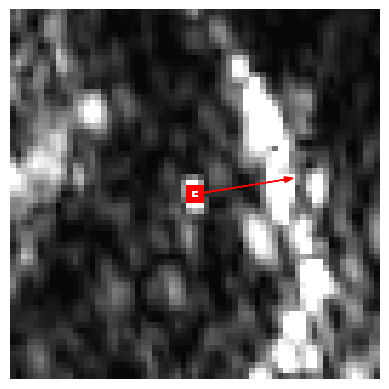

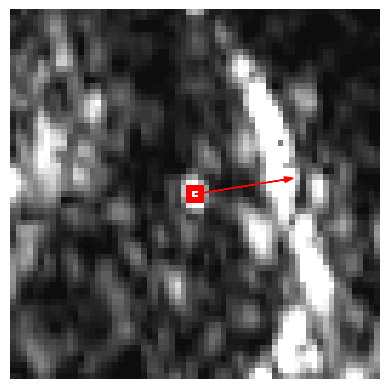

In [7]:
def single(lon, lat, h, off={}, wrf=0, length=32, step=1):
    x, y = wgs2utm(lon, lat)
    extent = np.arange(-length, length+1, step=step)
    xs, ys = np.meshgrid(extent+x, extent+y)
    lon, lat = utm2wgs(xs, ys)
    h = h * np.ones(lon.shape)

    imgs = {"ref": TH(ref_par, ref_cos), "sec": TH(sec_par, sec_cos)}
    for label, img in imgs.items():
        gen = img.indirect_with_offset(lon, lat, h, ref=imgs['ref'])
        sp = gen.send(None)
        if isinstance(wrf, int) or isinstance(wrf, float):
            offset, coe, cons = np.zeros(np.shape(lon)), 1, 0
        else:
            offset, coe, cons = wrf.cal_delays(sp, lon, lat, h)
        row, col = gen.send(offset / coe + cons)
        if len(off) != 0:
            row += off[label]['az']
            col += off[label]['rg']

        data = img.find(row, col)
        max_v = np.max(data)
        data = np.reshape(data, data.shape + (1,))
        data = np.repeat(data, 3, 2)
        delta_step = 1
        min_p = int((length-delta_step) / step)
        max_p = int((length+delta_step) / step)
        data[min_p:max_p+1, min_p] = [max_v, 0, 0]
        data[min_p:max_p+1, max_p] = [max_v, 0, 0]
        data[min_p, min_p:max_p+1] = [max_v, 0, 0]
        data[max_p, min_p:max_p+1] = [max_v, 0, 0]
        data = data / max_v
        plt.imshow(data, origin="lower")
        
        sp, tp = sp[:, 0, 0], wgs2ecs(lon[0, 0], lat[0, 0], h[0, 0])
        tp2 = 2* tp - sp
        tp2 = ecs2wgs(tp2[0], tp2[1], tp2[2])
        tp2 = wgs2utm(tp2[0], tp2[1])
        tp = wgs2utm(lon[0, 0], lat[0, 0])
        norm = np.linalg.norm((tp2[0] - tp[0], tp2[1] - tp[1]))*2
        x, y = (tp2[0] - tp[0])/norm*length, (tp2[1] - tp[1])/norm*length
        plt.arrow(length/step, length/step, x/step, y/step, color="red",head_width=1)
        
        plt.axis("off")
        plt.show()


def test_single(pid):
    ps = pd.read_csv(csv_path)
    p = ps.loc[ps['id'] == pid].iloc[0]
    lon, lat, h = p['lon'], p['lat'], p['h']
    wrf = Wrf(wrf_path)
    single(lon, lat, h, {"ref":{"az": -0.5, "rg":1.5}, "sec": {"az":-0.5, "rg":2.5}}, wrf=wrf)


test_single(10)